In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data = pd.read_csv('reddit_wsb.csv')
data.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      48260 non-null  object 
 1   score      48260 non-null  int64  
 2   id         48260 non-null  object 
 3   url        48260 non-null  object 
 4   comms_num  48260 non-null  int64  
 5   created    48260 non-null  float64
 6   body       22521 non-null  object 
 7   timestamp  48260 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.9+ MB


In [4]:
title_data = data[['title','timestamp']].copy()

title_data = title_data.dropna()

# Lower Case all posts 
title_data.title = title_data.title.str.lower()

# Remove Handlers
title_data.title = title_data.title.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove Urls
title_data.title = title_data.title.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all single charachters
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

#Remove Time From Timestamp
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date

In [8]:
sid = SIA()

title_data['sentiments'] = title_data['title'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
title_data['Positive Sentiment'] = title_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
title_data['Neutral Sentiment'] = title_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
title_data['Negative Sentiment'] = title_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

title_data.drop(columns=['sentiments'],inplace=True)
title_data.head()

,title,timestamp,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,"it's not about the money, it's about sendingme...",2021-01-28,0.000001,1.000001,0.000001
1,math professor scott steiner says the numbers ...,2021-01-28,0.000001,0.728001,0.272001
2,exit the system,2021-01-28,0.000001,1.000001,0.000001
3,new sec filing for gme! can someone less retar...,2021-01-28,0.138001,0.658001,0.204001
4,"not to distract from gme, just thought our amc...",2021-01-28,0.119001,0.881001,0.000001


In [9]:
# creating class from sentiment values
title_data['class_name'] = title_data[['Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment']].idxmax(axis=1)

In [10]:
# removing neutral class from reducing bias
data = title_data[title_data['class_name'] != 'Neutral Sentiment']
data.reset_index(drop=True, inplace=True)
data.head(5)

,title,timestamp,Positive Sentiment,Neutral Sentiment,Negative Sentiment,class_name
0,i love you retards!!!!,2021-01-28,0.677001,0.323001,0.000001,Positive Sentiment
1,the wallstreetbets war museum,2021-01-28,0.000001,0.435001,0.565001,Negative Sentiment
2,this took me longer than i'd like to admit. en...,2021-01-28,0.517001,0.483001,0.000001,Positive Sentiment
3,most recent short interest,2021-01-28,0.521001,0.479001,0.000001,Positive Sentiment
4,charitably-minded autists,2021-01-28,0.545001,0.455001,0.000001,Positive Sentiment


In [11]:
# total number of positive and negative sentiments
l = len(data[data['class_name'] == 'Negative Sentiment'])
print(f"There are {l} negative sentences")

m = len(data[data['class_name'] == 'Positive Sentiment'])
print(f"There are {m} positive sentences")

There are 1427 negative sentences
There are 2070 positive sentences


In [12]:
# replacing negative and positive sentiment in class with '0' and '1'
data['class_name'][data['class_name'] == 'Negative Sentiment'] = 0
data['class_name'][data['class_name'] == 'Positive Sentiment'] = 1

data.rename(columns={'class_name':'class'}, inplace=True)

Text(0, 0.5, 'Negative')

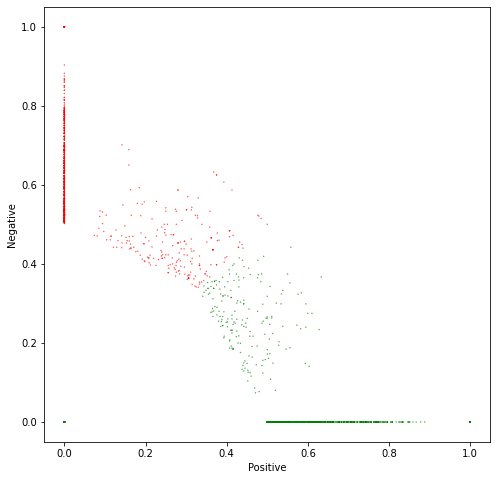

In [13]:
# Plotting Positive and Negative Sentiments
X = data[['Positive Sentiment', 'Negative Sentiment']].values
Y = data['class'].values;

fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red' , 'green']

# Color based on the sentiment Y
ax.scatter(X[:,0], X[:,1], c=[colors[int(k)] for k in Y], s=0.1)
plt.xlabel("Positive")
plt.ylabel("Negative")


##### Graph shows that the positive and negative sentiments are majorly separated so the accuracy should be high

In [14]:
data = data[['title','class']].copy()
data.head()

,title,class
0,i love you retards!!!!,1
1,the wallstreetbets war museum,0
2,this took me longer than i'd like to admit. en...,1
3,most recent short interest,1
4,charitably-minded autists,1


In [15]:
# creating training and testing data
split_ratio = int(len(data) * 0.8)
train_x = data['title'][:split_ratio]
test_x = data['title'][split_ratio:]
train_y = data['class'][:split_ratio]
test_y = data['class'][split_ratio:]

In [16]:
train_y = np.asarray(train_y, dtype='int32')
test_y = np.asarray(test_y, dtype='int32')

train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1,1)

In [17]:
def preprocess(sentence):
    
    sentence = sentence.lower()
    stemmer = PorterStemmer()
    
    tokenized = word_tokenize(sentence)
    cleaned_list = []
    
    stopwords_english = stopwords.words('english')
    
    for word in tokenized:
        if (word not in stopwords_english and word not in string.punctuation):
            stem_word = stemmer.stem(word)  
            cleaned_list.append(stem_word)
            
    return cleaned_list

In [21]:
# Take sentencess and their labels as input, go through every sentence, preprocess them, count the occurrence of every word in the data set and create a frequency dictionary.
def build_freqs(sentences, ys):

    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, sentence in zip(yslist, sentences):
        for word in preprocess(sentence):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

freqs = build_freqs(train_x, train_y)

## Building Logistic Regression Model

In [22]:
def sigmoid(z): 
    return (1 / (1 + np.exp(-z)))

In [25]:
def gradientDescent(x, y, theta, alpha, num_iters):
  m = len(x)
  for i in range(0, num_iters):
      z = np.dot(x, theta)
      h = sigmoid(z)
      J = (-1/m) * (np.dot((y.T), np.log(h)) + np.dot((1 - y).T, np.log(1 - h)))
      theta = theta - (alpha/m) * np.dot(x.T, (h - y))
      if i % (num_iters) == 0:
            print(i, J)
    
  J = float(J)
    
  return J, theta

In [23]:
def extract_features(sentence, freqs):

    word_l = preprocess(sentence)
    x = np.zeros((1, 3)) 
    
    x[0,0] = 1 
    
    for word in word_l:            
        x[0,1] += freqs[(word, 1)] if (word, 1) in freqs else 0
        
        x[0,2] += freqs[(word, 0)] if (word, 0.0) in freqs else 0 

    return x

In [26]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

Y = train_y

J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-5, 15000)

print(f"The cost after training is {J:.8f}.")

print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

0 [[0.69314718]]
The cost after training is 0.39880422.
The resulting vector of weights is [0.00151719, 0.03820472, -0.0342857]


In [27]:
# Given a sentence will predict the result using the ‘freqs’ dictionary and theta
def predict(sentence, freqs, theta):

    x = extract_features(sentence, freqs)

    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred

In [28]:
for text in ['I am happy', 'very bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (text, predict(text, freqs, theta)))

I am happy -> 0.548958
very bad -> 0.426708
this movie should have been great. -> 0.708490
great -> 0.692462
great great -> 0.835042
great great great -> 0.919230
great great great great -> 0.962387


In [29]:
def test_logistic_regression(test_x, test_y, freqs, theta):

    y_hat = []
    
    for sentence in test_x:
        y_pred = predict(sentence, freqs, theta)
        
        if y_pred > 0.5:
            y_hat.append(1.0)
        else:
            y_hat.append(0.0)

    accuracy = (np.array((y_hat)) == np.squeeze(test_y)).mean()

    return accuracy

tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.8986


In [30]:
text = 'Gamestop is high'
print(preprocess(text))
y_hat = predict(text, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['gamestop', 'high']
[[0.50552421]]
Positive sentiment
